## Rafael Espinosa Mena 
USC ID: 3587389751 <br>
GitHub Username: rafael6423 <br>
DSCI 552 HW6 <br>
Jul 4, 2022

In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor, sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

In [2]:
df_train = pd.read_csv('../data/aps_failure_training_set.csv')
df_test = pd.read_csv('../data/aps_failure_test_set.csv')
all_data = pd.concat([df_train, df_test], axis=0, ignore_index=True)

### 2.b.i) Commonly Used Methods for Imputation of Missing Values
Using the Mean/Median of the existing values in the column to replace all the missing values in the column, using the most common value in the column to replace all the missing values, using zero or a constant value to replace all the missing values, imputing by using knn to find the average value for that feature from the k-nearest observations that do have values for that feature, Multiple Imputation by Chained Equation (MICE) which imputs data with various different values to measures the uncertainty of the imputted value, using Deep Learning to impute values by using a NN to come up with a good estimate of what that value should be for that observation based on the others, other ML methods such as building a regression model on observations that do have values to "predict" what that value should be.

In [3]:
# impute function
def impute(df, method):
    class_col = pd.DataFrame(df['class'])
    df = df.drop(['class'], axis=1)
    df.replace(('na'), (np.nan), inplace=True)
    imp_mean = SimpleImputer(missing_values = np.nan, strategy = method)
    df_imp = pd.DataFrame(imp_mean.fit_transform(df))
    df_imp.columns = df.columns
    df_1 = pd.concat([class_col, df_imp], axis=1)
    return df_1 

# impute sets and separate x's and y
data_imp = impute(all_data, 'mean')
train_imp = impute(df_train, 'mean')
test_imp = impute(df_test, 'mean')

### 2.b.ii) Calculate CV for 170 Features

In [4]:
# create a dataframe to store cv values
cvs_df = pd.DataFrame(columns = ['Feature', 'CV'])

# calculate cv values
for column in data_imp.columns:
    if column != 'class':
        cv = data_imp[column].std()/data_imp[column].mean()
        cvs_df.loc[len(cvs_df),'Feature'] = column
        cvs_df.loc[len(cvs_df)-1,'CV'] = cv
    
# display cv values dataframe
cvs_df

,Feature,CV
0,aa_000,4.328608
1,ab_000,2.178273
2,ac_000,2.167653
3,ad_000,206.7215
4,ae_000,22.29367
...,...,...
165,ee_007,4.885098
166,ee_008,3.335037
167,ee_009,5.753933
168,ef_000,47.919544


### 2.b.iii) Correlation Matrix

In [5]:
corr_mat = data_imp.drop(['class'], axis=1).corr()
# Plot it numerically
print('Numerical Values of Matrix:')
display(corr_mat)
# Plot it with colors
#plt.figure(figsize=(25,25))
#sns.heatmap(corr_mat, cmap="Blues")
#plt.title('Correlation Matrix with Colors', fontsize = 25)
#plt.show()

Numerical Values of Matrix:


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019725,-0.011658,-0.000541,0.025795,0.035994,0.011682,0.076378,0.195161,0.307443,...,0.414125,0.419912,0.409659,0.419780,0.425679,0.356969,0.259668,0.133764,0.006688,0.010330
ab_000,0.019725,1.000000,-0.010898,0.000066,0.024869,0.043276,0.000590,0.006547,0.023484,0.035696,...,0.025161,0.037052,0.028766,0.034201,0.023921,0.013598,0.002371,0.000506,0.046897,0.075683
ac_000,-0.011658,-0.010898,1.000000,-0.002030,-0.004769,-0.010612,0.015534,-0.002333,-0.009439,-0.022889,...,-0.009808,-0.006437,-0.007962,-0.008115,-0.014680,-0.018631,0.010435,0.017293,-0.006191,0.015826
ad_000,-0.000541,0.000066,-0.002030,1.000000,-0.000195,-0.000236,-0.000038,-0.000034,-0.000093,-0.000223,...,-0.000883,-0.000921,-0.000908,-0.000730,-0.000745,-0.000462,-0.000794,-0.000500,-0.000082,-0.000091
ae_000,0.025795,0.024869,-0.004769,-0.000195,1.000000,0.829986,-0.000441,-0.000609,0.001948,0.020678,...,0.012751,0.019441,0.012847,0.026437,0.066533,0.036619,-0.008393,-0.006952,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013598,-0.018631,-0.000462,0.036619,0.046482,0.007631,0.068003,0.181967,0.475570,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227098,0.063065,-0.000309,0.000946
ee_008,0.259668,0.002371,0.010435,-0.000794,-0.008393,-0.010843,0.000067,0.005353,0.009109,0.020684,...,0.442532,0.470574,0.448390,0.394020,0.365686,0.227098,1.000000,0.690147,-0.005173,-0.001950
ee_009,0.133764,0.000506,0.017293,-0.000500,-0.006952,-0.008539,-0.001103,-0.003540,-0.009089,-0.018164,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003168,-0.001059
ef_000,0.006688,0.046897,-0.006191,-0.000082,0.063587,0.093474,-0.000076,0.001140,0.005625,0.011036,...,0.003718,0.010177,0.002989,0.026924,0.005298,-0.000309,-0.005173,-0.003168,1.000000,0.222579


### 2.b.iv) Scatter/Boxplots of floor(sqrt(170)) Values With Highest CV

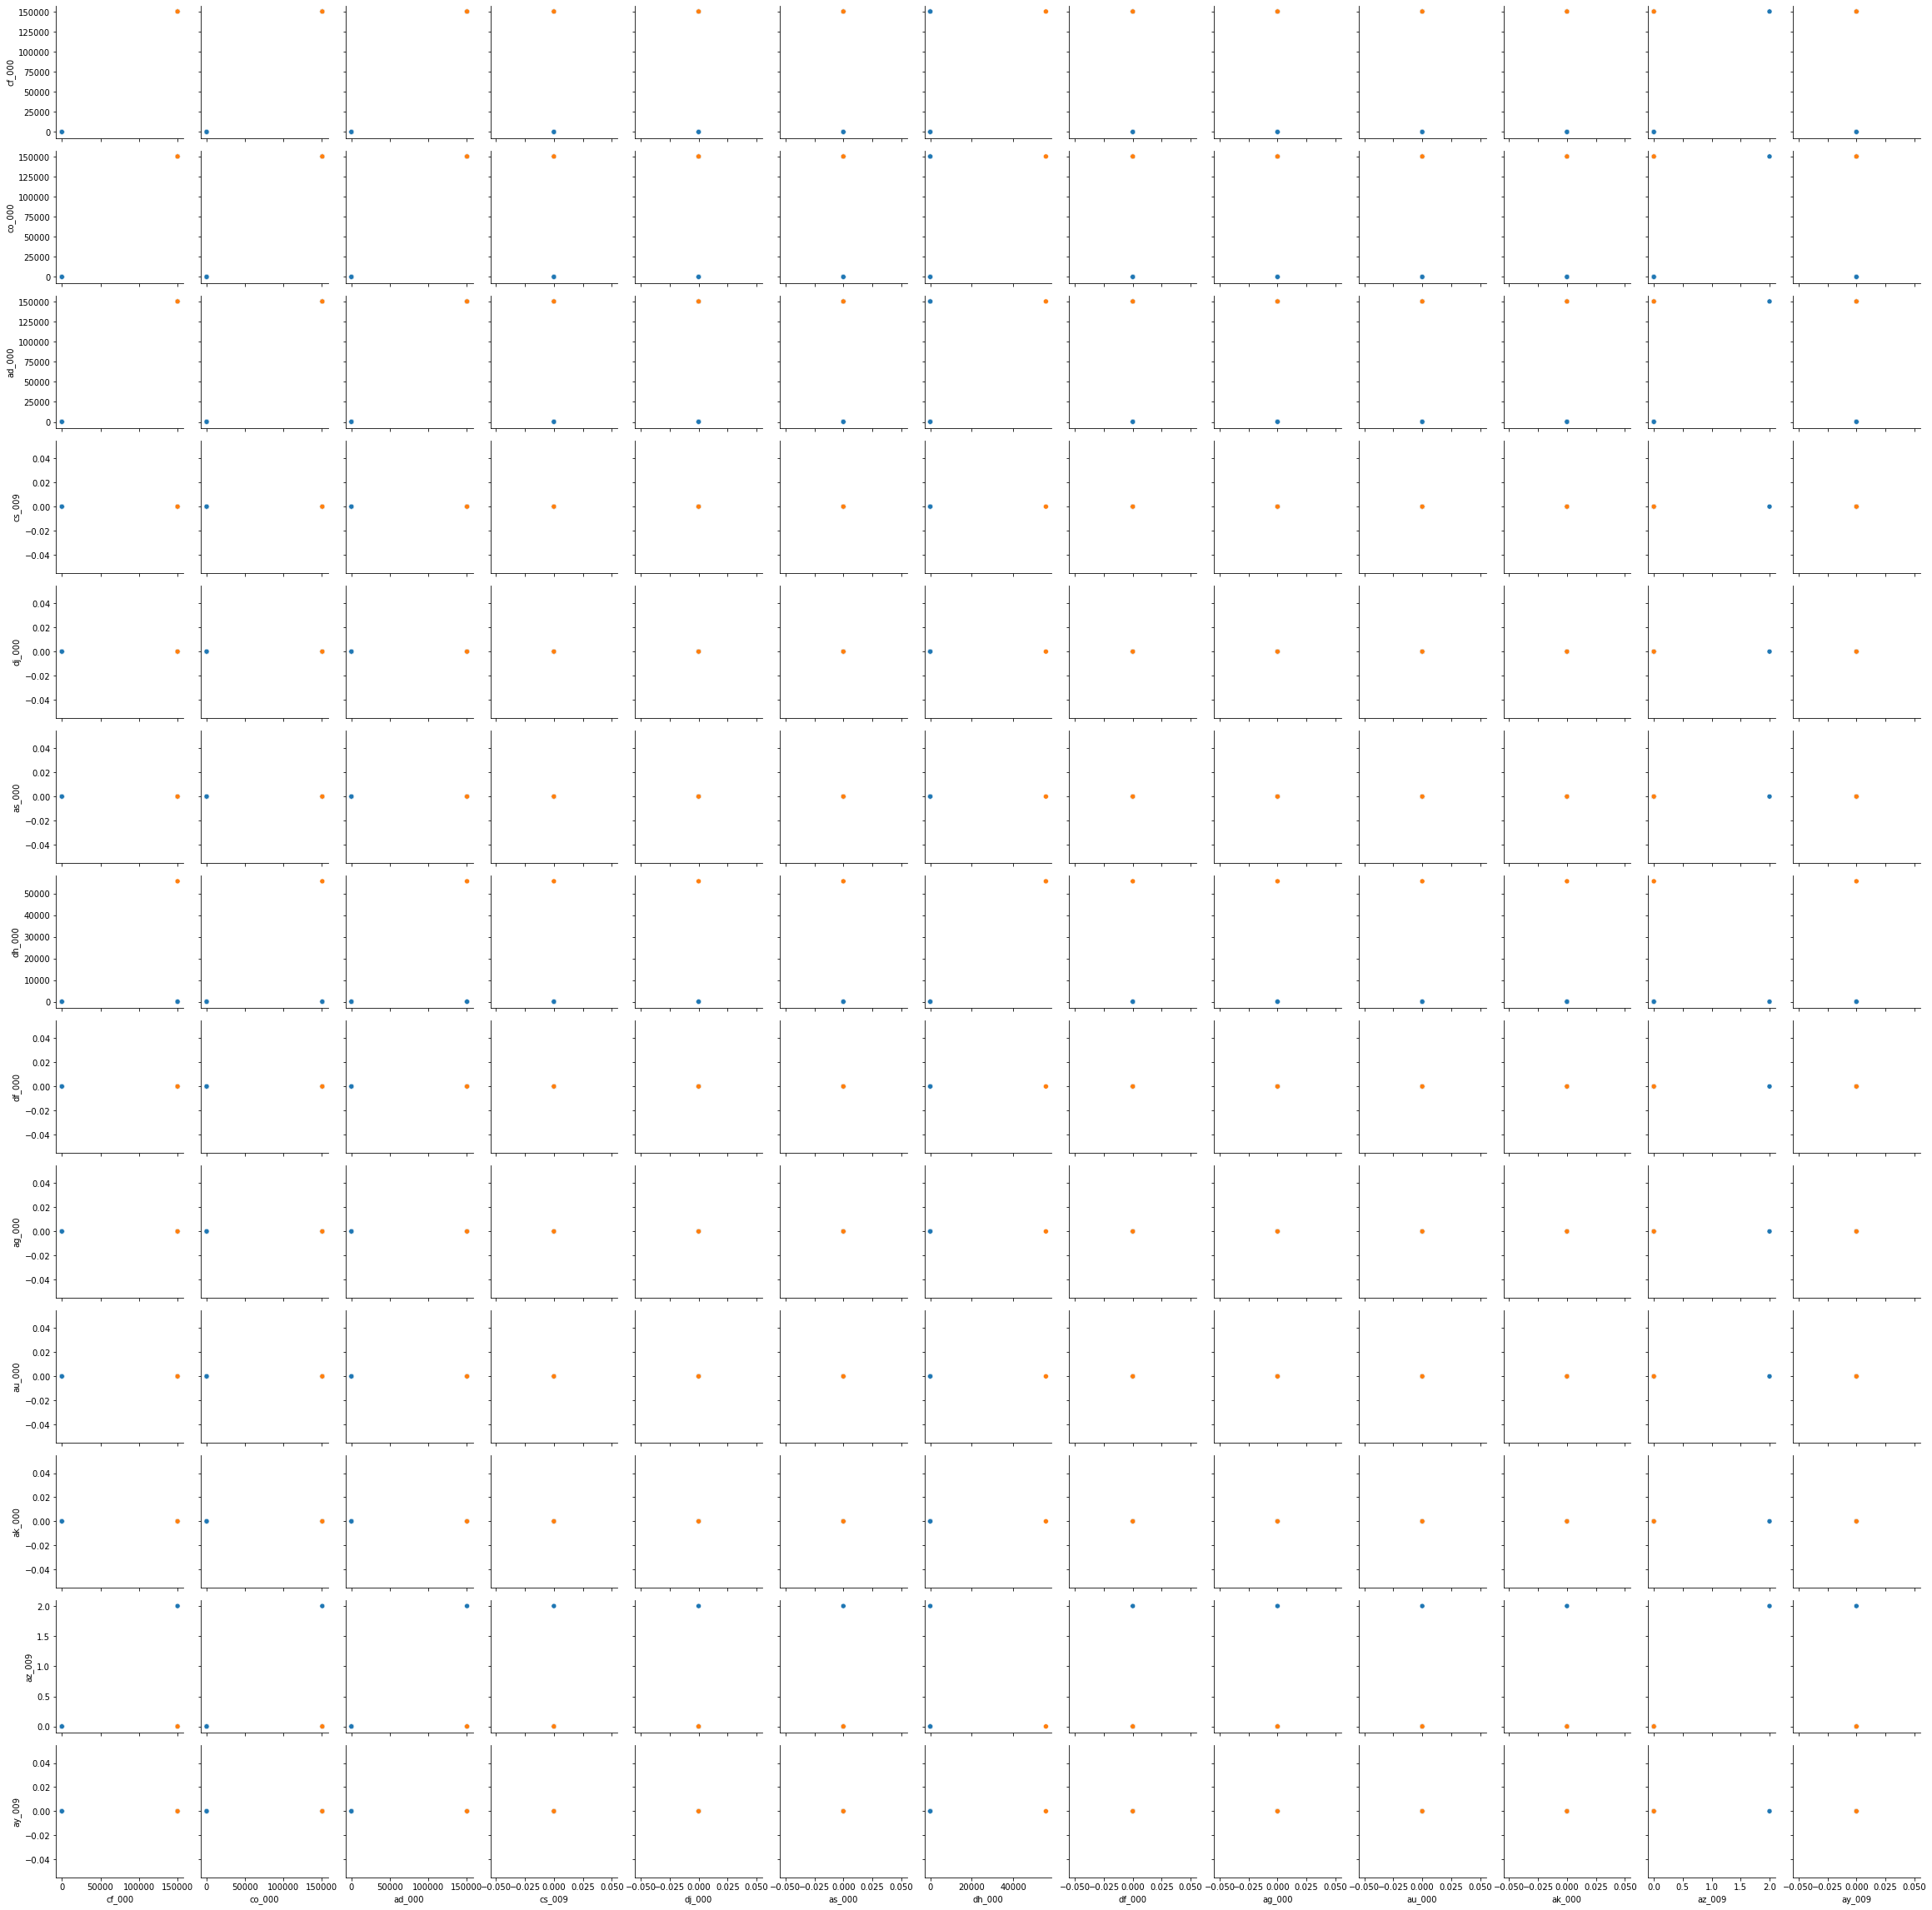

In [6]:
# select the 13 highest CV's
num = floor(sqrt(170))
cvs_df = cvs_df.sort_values('CV', ascending=False, ignore_index = True).iloc[:num,:]

# ScatterPlots
plot_data = data_imp.iloc[:10,:][pd.concat([pd.Series(['class']),cvs_df.Feature], ignore_index=True)]
g = sns.PairGrid(plot_data, hue='class')
g.map(sns.scatterplot)

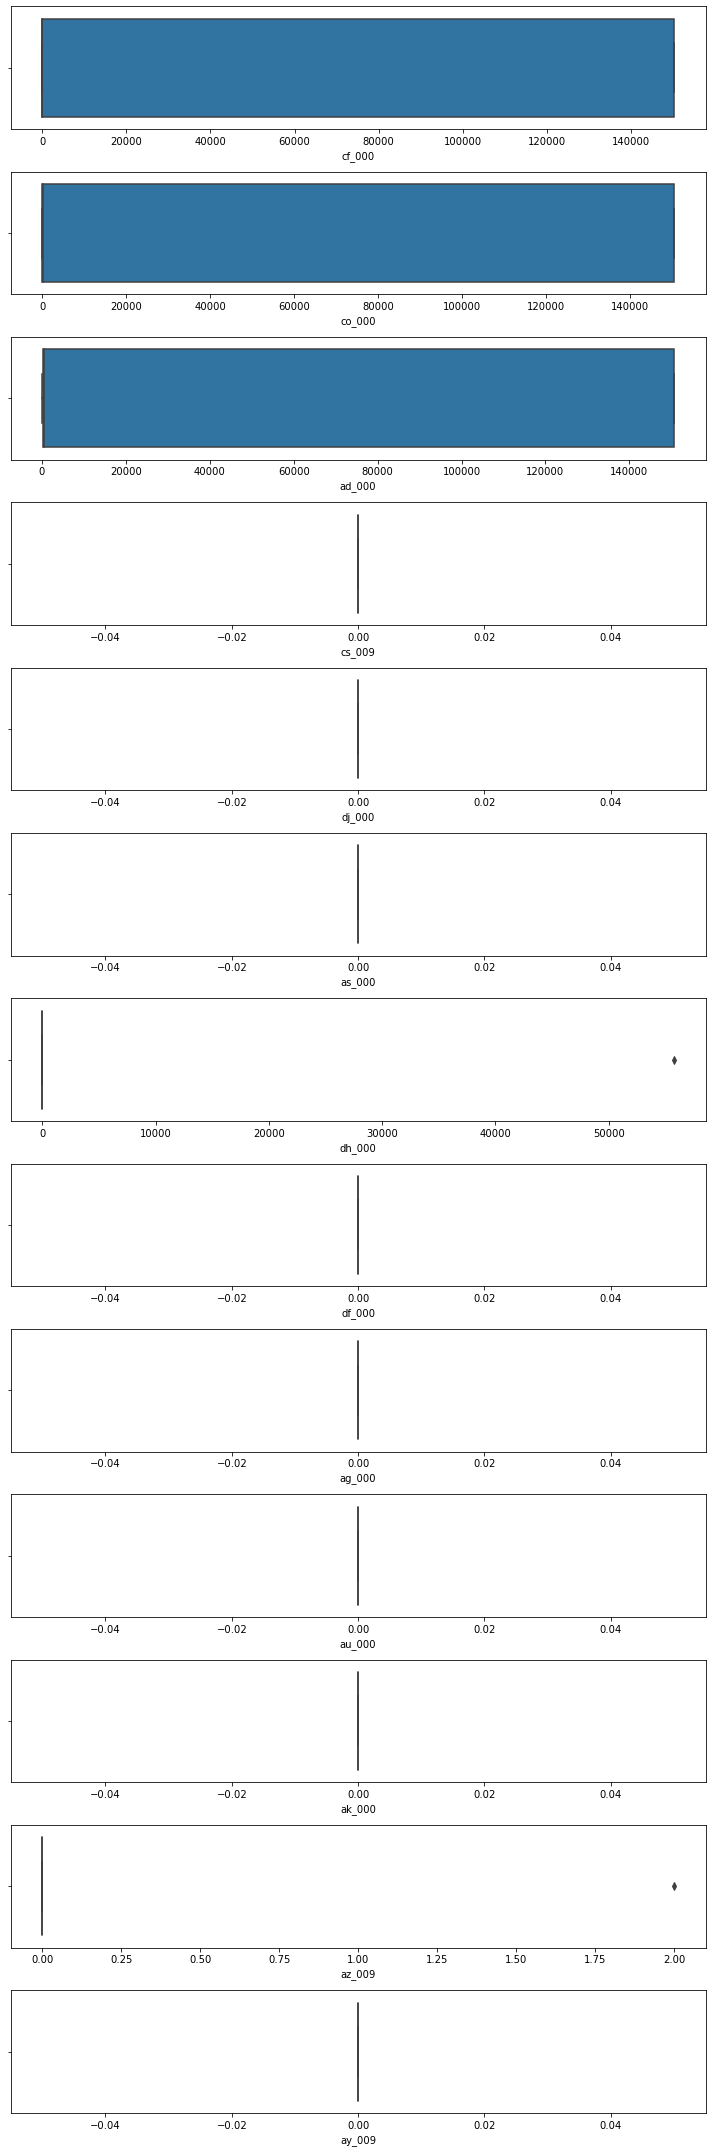

In [7]:
# BoxPlots
fig, axes = plt.subplots(13, 1, figsize=(10,30))
box_data = plot_data.drop(['class'], axis=1)
for i in range(0,13):
    ax = sns.boxplot(x=box_data.columns[i], data=box_data, ax=axes[i])
fig.tight_layout()
plt.show()

### 2.b.v) Determine Number of Positive/Negative Data

In [8]:
print("Train Set Distribution:")
display(df_train['class'].value_counts())
print("Test Set Distribution:")
display(df_test['class'].value_counts())
print("Whole Set Distribution:")
display(data_imp['class'].value_counts())

Train Set Distribution:


neg    59000
pos     1000
Name: class, dtype: int64

Test Set Distribution:


neg    15625
pos      375
Name: class, dtype: int64

Whole Set Distribution:


neg    74625
pos     1375
Name: class, dtype: int64

As we can see, in all of the data there are 74625 negatives and only 1375 positives, meaning that the positives are only 1.8% of the data. Within the training set, this is even more drastic because the positives are only 1.67% of the data points, so this dataset is definetly imbalanced.

### 1.c) Random Forest Classifier Without Class Imbalance Compensation

In [9]:
# create data
y_train = train_imp['class'].map({"pos":1, "neg":0})
x_train = train_imp.drop(['class'], axis=1)
y_test = test_imp['class'].map({"pos":1, "neg":0})
x_test = test_imp.drop(['class'], axis=1)

# create and fit model
clf = RandomForestClassifier(random_state=0, oob_score=True)
clf.fit(x_train, y_train)

# create predictions
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

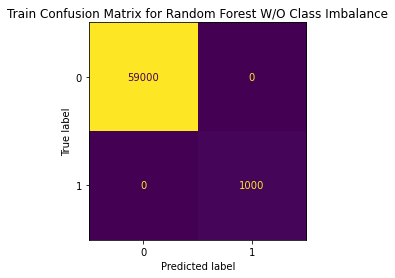

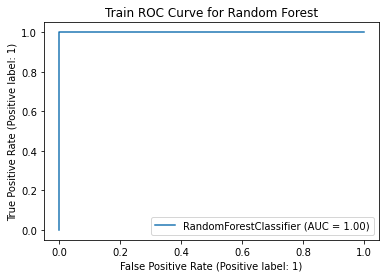

Train AUC Score for Random Forest is 1.0
Train OOB Error for Random Forest is 0
Train Misclassification Rate for Random Forest is 0.0


In [10]:
# Calculations for Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for Random Forest W/O Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, x_train, y_train)
plt.title('Train ROC Curve for Random Forest')
plt.show()

# Scores 
print("Train AUC Score for Random Forest is", roc_auc_score(y_train, train_pred))
print("Train OOB Error for Random Forest is", 1-clf.oob_score)
print("Train Misclassification Rate for Random Forest is", 1-accuracy_score(y_train, train_pred))

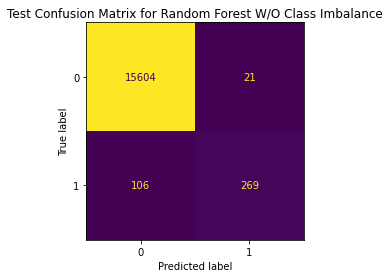

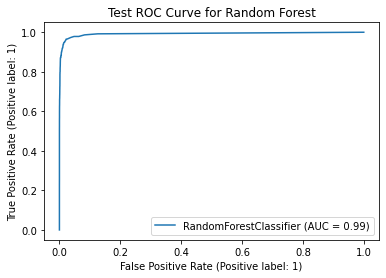

Test AUC Score for Random Forest is 0.8579946666666667
Test OOB Error for Random Forest is 0
Test Misclassification Rate for Random Forest is 0.007937500000000042


In [11]:
# Calculations for Test Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for Random Forest W/O Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title('Test ROC Curve for Random Forest')
plt.show()

# Scores 
print("Test AUC Score for Random Forest is", roc_auc_score(y_test, test_pred))
print("Test OOB Error for Random Forest is", 1-clf.oob_score)
print("Test Misclassification Rate for Random Forest is", 1-accuracy_score(y_test, test_pred))

### 1.d)  Random Forest with Class Imbalance Compensation

From my research, I can see tthat one common method to deal with class imbalances in Random Forest Classfiers is to make class priors equal by downsampling or upsampling by drawing bootstrap samples of equal proportions from the both the minority and majority class. In practice, we can directly use a balanced RFC from imblearn or use the typical sklearn RFC but setting the class_weight attribute to 'balanced', and that way it will select points at a rate inversely proportional to how frequent they appear in data.

In [12]:
# create and fit model
clf_balanced = RandomForestClassifier(random_state=0, oob_score=True, class_weight="balanced")
clf_balanced.fit(x_train, y_train)

# create predictions
train_pred = clf_balanced.predict(x_train)
test_pred = clf_balanced.predict(x_test)

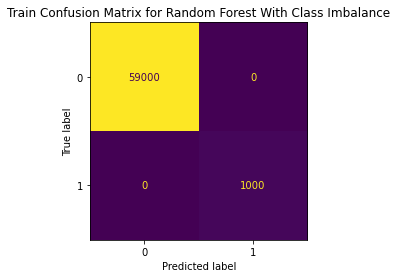

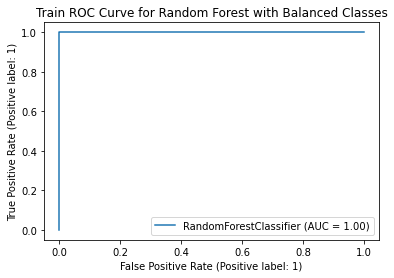

Balanced Train AUC Score for Random Forest is 1.0
Balanced Train OOB Error for Random Forest is 0
Balanced Train Misclassification Rate for Random Forest is 0.0


In [13]:
# Calculations for Training Set (Class Balanced)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for Random Forest With Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf_balanced, x_train, y_train)
plt.title('Train ROC Curve for Random Forest with Balanced Classes')
plt.show()

# Scores 
print("Balanced Train AUC Score for Random Forest is", roc_auc_score(y_train, train_pred))
print("Balanced Train OOB Error for Random Forest is", 1-clf.oob_score)
print("Balanced Train Misclassification Rate for Random Forest is", 1-accuracy_score(y_train, train_pred))

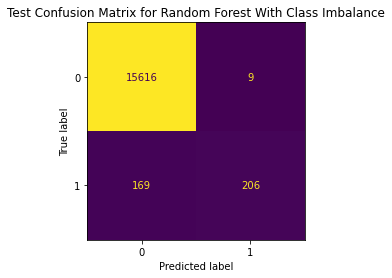

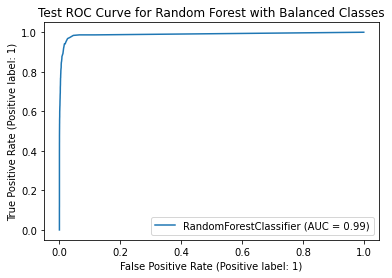

Balanced Test AUC Score for Random Forest is 0.7743786666666665
Balanced Test OOB Error for Random Forest is 0
Balanced Test Misclassification Rate for Random Forest is 0.011125000000000052


In [14]:
# Calculations for Test Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for Random Forest With Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf_balanced, x_test, y_test)
plt.title('Test ROC Curve for Random Forest with Balanced Classes')
plt.show()

# Scores 
print("Balanced Test AUC Score for Random Forest is", roc_auc_score(y_test, test_pred))
print("Balanced Test OOB Error for Random Forest is", 1-clf.oob_score)
print("Balanced Test Misclassification Rate for Random Forest is", 1-accuracy_score(y_test, test_pred))

### 1.e) XGBoost and Model Trees

In [21]:
alpha_param = [{'reg_alpha': np.logspace(-1,1,3)}]

# 5 fold CV
k_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
xgb_cl = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0, 
                           reg_alpha=xgb_gs.best_params_['reg_alpha'])
xgb_cl.fit(x_train, y_train)



In [23]:
np.logspace(-1,1,6)

array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])